In [1]:
import math, random, copy
import gym
import numpy as np
import pickle as pkl
from matplotlib.image import imsave
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
import matplotlib.pyplot as plt

USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda' if USE_CUDA else 'cpu')
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)


In [2]:
class ReplayBuffer:
  def __init__(self,capacity): 
    self.capacity = capacity
    self.buffer = []
    self.position = 0

  def push(self, state, action, reward, next_state, done):
      state      = np.expand_dims(state, 0)
      next_state = np.expand_dims(next_state, 0)
          
      self.buffer.append((state, action, reward, next_state, done))
  
  def sample(self, batch_size):
      state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
      return np.concatenate(state), action, reward, np.concatenate(next_state), done
  
  def __len__(self):
      return len(self.buffer)

In [3]:
class StochasticMDP:
    def __init__(self):
        self.end           = False
        self.current_state = 2
        self.num_actions   = 2
        self.num_states    = 6
        self.p_right       = 0.5

    def reset(self):
        self.end = False
        self.current_state = 2
        state = np.zeros(self.num_states)
        state[self.current_state - 1] = 1.
        return state

    def step(self, action):
        if self.current_state != 1:
            if action == 1:
                if random.random() < self.p_right and self.current_state < self.num_states:
                    self.current_state += 1
                else:
                    self.current_state -= 1
                    
            if action == 0:
                self.current_state -= 1
                
            if self.current_state == self.num_states:
                self.end = True
        
        state = np.zeros(self.num_states)
        state[self.current_state - 1] = 1.
        
        if self.current_state == 1:
            if self.end:
                return state, 1.00, True, {}
            else:
                return state, 1.00/100.00, True, {}
        else:
            return state, 0.0, False, {}

In [10]:
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.num_outputs = num_outputs
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128, num_outputs),
            nn.Softmax()
        )
    
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state  = torch.FloatTensor(state).unsqueeze(0)
            action = self.forward(Variable(state, volatile=True)).max(1)[1]
            return action.item()
        else:
            return random.randrange(self.num_outputs)

In [16]:
def update(batch_size):
    teacher_state, teacher_action, teacher_reward, teacher_next_state, teacher_done = teacher_replay_buffer.sample(batch_size)
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    state      = Variable(torch.FloatTensor(state))
    next_state = Variable(torch.FloatTensor(next_state), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    teacher_state      = Variable(torch.FloatTensor(teacher_state))
    teacher_next_state = Variable(torch.FloatTensor(teacher_next_state), volatile=True)
    teacher_action     = Variable(torch.LongTensor(teacher_action))
    teacher_reward     = Variable(torch.FloatTensor(teacher_reward))
    teacher_done       = Variable(torch.FloatTensor(teacher_done))
    
    #Model update
    q_value = model(state)
    q_value = q_value.gather(1, action.unsqueeze(1)).squeeze(1)    
    teacher_q_value = teacher_model(teacher_state)
    teacher_q_value = teacher_q_value.gather(1, teacher_action.unsqueeze(1)).squeeze(1)
    expected_q_value = reward + 0.99 * teacher_q_value * (1 - done)
#     loss = (reward - teacher_prim_reward).pow(2).mean()
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Teacher update
    next_q_value     = teacher_model(teacher_next_state).max(1)[0]
    expected_q_value = teacher_reward + 0.99 * next_q_value * (1 - teacher_done)
    teacher_loss = (teacher_q_value - Variable(expected_q_value.data)).pow(2).mean()
    teacher_optimizer.zero_grad()
    teacher_loss.backward()
    teacher_optimizer.step()
    
    return loss,teacher_loss

In [17]:
env = gym.make('CartPole-v0')#StochasticMDP()
learning_rate = 0.001
model        = Net(env.observation_space.shape[0]+2, env.action_space.n).to(device)
teacher_model        = Net(env.observation_space.shape[0]+2, env.action_space.n).to(device)
optimizer      = optim.Adam(model.parameters(),lr=learning_rate)
teacher_optimizer      = optim.Adam(model.parameters(),lr=learning_rate)

replay_buffer      = ReplayBuffer(1000000)
teacher_replay_buffer      = ReplayBuffer(1000000)
replay_initial = 100

load_model = False
if load_model==True:
    model_checkpoint = torch.load('./Checkpoint/model.pth.tar', map_location=device) 
    model.load_state_dict(model_checkpoint['model_state_dict'])
    optimizer.load_state_dict(model_checkpoint['optimizer_state_dict'])
    loss = model_checkpoint['loss']

load_teacher_model = False
if load_teacher_model==True:
    teacher_model_checkpoint = torch.load('./Checkpoint/teacher_model.pth.tar', map_location=device) 
    teacher_model.load_state_dict(teacher_model_checkpoint['model_state_dict'])
    teacher_optimizer.load_state_dict(teacher_model_checkpoint['optimizer_state_dict'])
    teacher_loss = model_checkpoint['loss']

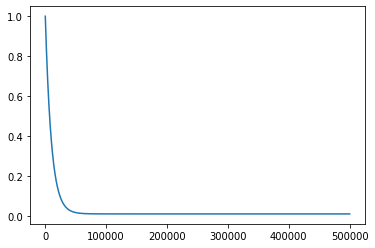

In [18]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 10000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)
plt.figure()
plt.plot([epsilon_by_frame(i) for i in range(500000)])

In [19]:
#ONLY FOR ATARI
action = 1
def process_atari(state):
    action = 1
    for _ in range(3):
        next_state, reward, done, _ = env.step(action)
        state = np.concatenate((state,next_state),0)
    return state

In [21]:
num_frames = 10000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
avg_rewards = []
episode_reward = 0
avg_reward = 0

teacher_losses = []
teacher_all_rewards = []
teacher_avg_rewards = []
teacher_episode_reward = 0
teacher_avg_reward = 0

state_rewards = []
teacher_reward = 0
teacher_action = 1
next_state = env.reset()
# state = process_atari(state)
print(next_state.shape)
for frame_idx in range(1, num_frames + 1):
#     env_teacher = copy.deepcopy(env)
    epsilon = epsilon_by_frame(frame_idx)
    state = np.concatenate((next_state,np.array([teacher_action]),np.array([teacher_reward])),0)
    
    action = model.act(state, epsilon)
    next_state, reward, done, _ = env.step(action)
    state_rewards.append(reward)
    if (action==teacher_action):
        reward += 0.1*abs(reward)
    
    env_teacher = copy.deepcopy(env)
    teacher_state = np.concatenate((next_state,np.array([action]),np.array([reward])),0)
    teacher_action = teacher_model.act(state, epsilon)
    teacher_next_state, teacher_reward, teacher_done, _ = env_teacher.step(teacher_action)
#     if (reward>state_rewards[-1]):
#         teacher_reward += 0.2*teacher_reward
    
    #Auxilary step for teacher's next-state update
    aux_state = np.concatenate((teacher_next_state,np.array([teacher_action]),np.array([teacher_reward])),0)
    aux_action = model.act(aux_state, epsilon)
    aux_next_state, aux_reward, aux_done, _ = env_teacher.step(aux_action)
    teacher_next_state = np.concatenate((aux_next_state,np.array([aux_action]),np.array([aux_reward])),0)
    
    teacher_replay_buffer.push(teacher_state, teacher_action, teacher_reward, teacher_next_state, teacher_done)
    replay_buffer.push(state, action, reward, next_state, done)
#     state = np.concatenate((state[1:,:,:],next_state),0)
    episode_reward += reward
    teacher_episode_reward += teacher_reward
    
    # if frame_idx in range(15000,20000):
    #   imsave(checkpoint_name+'/Frames/'+str(frame_idx)+'.png',next_state[0,:,:])

    if done:
        next_state = env.reset()
#         state = process_atari(state)
        all_rewards.append(episode_reward)
        avg_rewards.append(avg_reward)
        episode_reward = 0
        teacher_all_rewards.append(teacher_episode_reward)
        teacher_avg_rewards.append(teacher_avg_reward)
        teacher_episode_reward = 0
        teacher_reward = 0
        teacher_action = 1

        
    if len(replay_buffer) > batch_size:
        loss,teacher_loss = update(batch_size)
        loss = loss.item()
        losses.append(loss)
        teacher_loss = teacher_loss.item()
        teacher_losses.append(teacher_loss)
                
    if frame_idx % 1000 == 0:
        avg_reward = np.mean(all_rewards[-1000:])
        teacher_avg_reward = np.mean(teacher_all_rewards[-1000:])
        print('Step-',frame_idx,'/',num_frames,'|Episode Reward-',all_rewards[-1],'|Loss-',loss)
        print('Teacher Episode Reward-',teacher_all_rewards[-1],'Teacher Loss-',teacher_loss)
        torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'loss': loss},
                   './Checkpoint/model.pth.tar')
        torch.save({'model_state_dict': teacher_model.state_dict(), 'optimizer_state_dict': teacher_optimizer.state_dict(),
                    'loss': teacher_loss},'./Checkpoint/teacher_model.pth.tar')
        # plt.plot(all_rewards)

data_save = {}
data_save['loss'] = losses
data_save['reward'] = all_rewards
data_save['avg_reward'] = avg_rewards

teacher_data_save = {}
teacher_data_save['loss'] = teacher_losses
teacher_data_save['reward'] = teacher_all_rewards
teacher_data_save['avg_reward'] = teacher_avg_rewards

with open('./Checkpoint/data_save.pkl', 'wb') as f: #data+same as frame folder
    pkl.dump(data_save, f)

with open('./Checkpoint/teacher_data_save.pkl', 'wb') as f: #data+same as frame folder
    pkl.dump(teacher_data_save, f)


(4,)


K:\Users\Karush Suri\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


Step- 1000 / 500000 |Episode Reward- 11.4 |Loss- 1.1801228523254395
Teacher Episode Reward- 10.0 Teacher Loss- 0.910210371017456
Step- 2000 / 500000 |Episode Reward- 26.400000000000006 |Loss- 1.1229420900344849
Teacher Episode Reward- 24.0 Teacher Loss- 0.941811203956604
Step- 3000 / 500000 |Episode Reward- 34.80000000000001 |Loss- 1.032637357711792
Teacher Episode Reward- 32.0 Teacher Loss- 0.9308387637138367
Step- 4000 / 500000 |Episode Reward- 27.300000000000008 |Loss- 1.114243507385254
Teacher Episode Reward- 25.0 Teacher Loss- 0.8486908674240112
Step- 5000 / 500000 |Episode Reward- 56.90000000000003 |Loss- 0.9448508620262146
Teacher Episode Reward- 53.0 Teacher Loss- 0.958681046962738
Step- 6000 / 500000 |Episode Reward- 48.30000000000001 |Loss- 1.0295122861862183
Teacher Episode Reward- 45.0 Teacher Loss- 0.9134373664855957
Step- 7000 / 500000 |Episode Reward- 13.7 |Loss- 0.92139732837677
Teacher Episode Reward- 12.0 Teacher Loss- 0.9579387307167053
Step- 8000 / 500000 |Episode R

KeyboardInterrupt: 

In [ ]:
# Results for Model
plt.figure()
plt.plot(avg_rewards)

plt.figure()
plt.plot(losses)


In [ ]:
# Results for Teacher
plt.figure()
plt.plot(teacher_avg_rewards)

plt.figure()
plt.plot(teacher_losses)
